## Imports

In [1]:
import os
from PIL import Image

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import timm
from timm import create_model

from tqdm import tqdm

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

## Dataset Exploration

In [2]:
# Define dataset root
dataset_path = "/kaggle/input/commontest01/dataset/val"

# Class names
class_names = ["no", "sphere", "vort"]

# Storage for stats
shape_counts = {}
class_counts = {name: 0 for name in class_names}
pixel_values = []

# Iterate through classes
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.exists(class_dir):
        for file in os.listdir(class_dir):
            if file.endswith(".npy"):
                file_path = os.path.join(class_dir, file)
                img = np.load(file_path)  # Load numpy array

                # Track shapes
                shape = img.shape
                shape_counts[shape] = shape_counts.get(shape, 0) + 1

                # Track min/max pixel values
                pixel_values.append((img.min(), img.max()))

                # Count class samples
                class_counts[class_name] += 1

# Print findings
print("✅ Image Shape Distribution:", shape_counts)
print("✅ Class Distribution:", class_counts)
print("✅ Pixel Value Ranges:", set(pixel_values))


✅ Image Shape Distribution: {(1, 150, 150): 7500}
✅ Class Distribution: {'no': 2500, 'sphere': 2500, 'vort': 2500}
✅ Pixel Value Ranges: {(0.0, 1.0)}


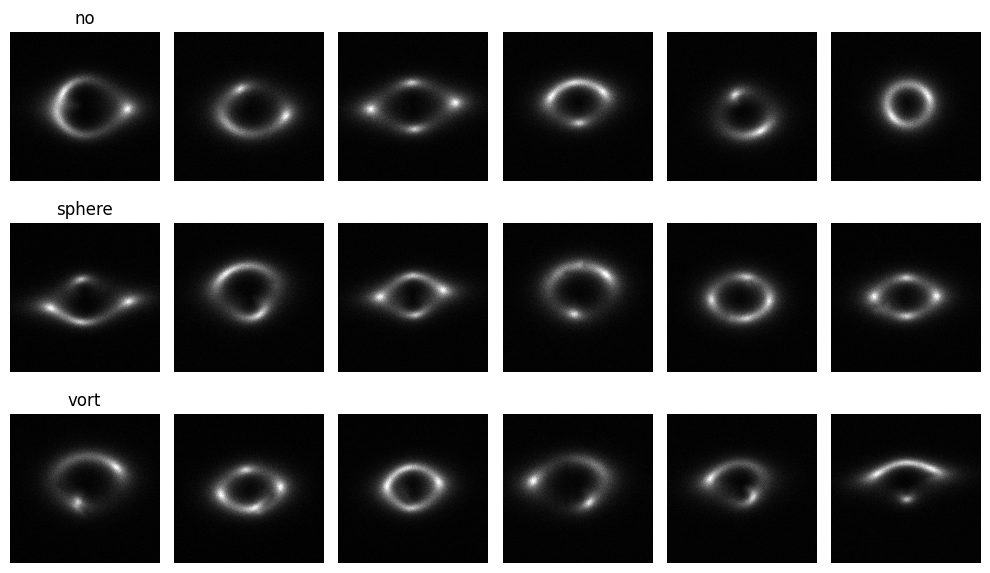

In [3]:
# Function to display images
def show_sample_images(dataset_path, class_names, num_samples=6):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(10, 6))
    
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        files = [f for f in os.listdir(class_dir) if f.endswith(".npy")]
        
        for j in range(num_samples):
            img = np.load(os.path.join(class_dir, files[j]))
            img = img.squeeze()  # Remove channel dim (1, H, W) -> (H, W)
            
            axes[i, j].imshow(img, cmap="gray")
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name)

    plt.tight_layout()
    plt.show()

# Show samples
show_sample_images(dataset_path, class_names)

## Helpful

In [4]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

def plot_tensor_image(tensor, title="Image"):
    """
    Plots a PyTorch tensor as an image.
    
    Args:
        tensor (torch.Tensor): Image tensor of shape (C, H, W) or (H, W).
        title (str): Title of the plot.
    """
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu()  # Ensure it's on CPU and detached from the graph
    
    if tensor.ndim == 3 and tensor.shape[0] in [1, 3]:  # (C, H, W) format
        tensor = tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    elif tensor.ndim == 2:  # Grayscale image (H, W)
        tensor = tensor.numpy()
    
    # Normalize if needed (convert values to range [0,1])
    if tensor.max() > 1:
        tensor = tensor / 255.0  

    plt.imshow(tensor, cmap="gray" if tensor.shape[-1] == 1 else None)
    plt.axis("off")
    plt.title(title)
    plt.show()

## DataLoader

In [5]:
class NumpyImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, repeating_channels=True):
        self.root_dir = root_dir
        self.transform = transform
        self.repeating_channels = repeating_channels
        self.samples = []
        self.label_map = {"no": 0, "sphere": 1, "vort": 2}  # Class mapping

        # Collect all .npy file paths and labels
        for class_name, label in self.label_map.items():
            class_path = os.path.join(root_dir, class_name)
            if os.path.exists(class_path):
                for file in os.listdir(class_path):
                    if file.endswith(".npy"):
                        self.samples.append((os.path.join(class_path, file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        img = np.load(file_path)  # Load (1, H, W) array

        # Convert (1, H, W) -> (H, W, 3) by repeating channels
        if self.repeating_channels:
            img = np.repeat(img, 3, axis=0)  # Now (3, H, W)
        # print(img.shape, type(img))
        img = np.transpose(img, (1, 2, 0))  # (H, W, 3)
        img = Image.fromarray(np.uint8(img * 255))  # Ensure it's scaled correctly if needed
        # print(type(img))

        # Apply optional transformations
        if self.transform:
            img = self.transform(img)
        # print(img.shape)
        return img, label

## Model Architecture

### baby model

In [6]:
class LensModel(nn.Module):
    """
    A PyTorch neural network model for classifying images based on lens type.

    Args:
        num_classes (int): The number of classes to classify.
        in_channels (int, optional): The number of input channels. Defaults to 1.

    Attributes:
        conv1 (nn.Conv2d): The first convolutional layer.
        bn1 (nn.BatchNorm2d): The first batch normalization layer.
        relu1 (nn.ReLU): The first ReLU activation layer.
        conv2 (nn.Conv2d): The second convolutional layer.
        bn2 (nn.BatchNorm2d): The second batch normalization layer.
        relu2 (nn.ReLU): The second ReLU activation layer.
        pool (nn.AdaptiveAvgPool2d): The adaptive average pooling layer.
        fc (nn.Linear): The fully connected output layer.
        softmax (nn.Softmax): The softmax activation layer.

    """
    def __init__(self, num_classes, in_channels=1):
        super(LensModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(inplace=True)
        
        #self.conv3 = nn.Conv2d(in_channels=128, out_channels=1024, kernel_size=3, stride=1, padding=1)
        #self.bn3 = nn.BatchNorm2d(1024)
        #self.relu3 = nn.ReLU(inplace=True)
        
        #self.conv4 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, stride=1, padding=1)
        #self.bn4 = nn.BatchNorm2d(256)
        #self.relu4 = nn.ReLU(inplace=True)

        #self.conv5 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, stride=1, padding=1)
        #self.bn5 = nn.BatchNorm2d(256)
        #self.relu5 = nn.ReLU(inplace=True)

        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(in_features=256, out_features=num_classes)

        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        """
        Compute forward pass through the neural network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        #x = self.relu3(self.bn3(self.conv3(x)))
        #x = self.relu4(self.bn4(self.conv4(x)))
        #x = self.relu5(self.bn5(self.conv5(x)))

        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        x = self.softmax(x)
        
        return x

### PreTrained Models

In [7]:
def modify_vit_for_grayscale(vit_model):
    """
    Modifies a Vision Transformer (ViT) model to accept grayscale (1-channel) images instead of RGB (3-channel).

    Args:
        vit_model: Pretrained ViT model from timm or torchvision.

    Returns:
        Modified ViT model.
    """
    # Get the patch embedding layer
    patch_embed = vit_model.patch_embed

    # Create a new layer with input channel changed from 3 → 1
    new_patch_embed = torch.nn.Conv2d(
        in_channels=1,  # Change input channels to 1 (grayscale)
        out_channels=patch_embed.proj.out_channels,  # Keep the same output channels
        kernel_size=patch_embed.proj.kernel_size,  # Keep the kernel size
        stride=patch_embed.proj.stride,  # Keep the stride
        padding=patch_embed.proj.padding,  # Keep the padding
        bias=patch_embed.proj.bias is not None  # Keep bias settings
    )

    # Copy weights by averaging across RGB channels
    with torch.no_grad():
        new_patch_embed.weight[:] = patch_embed.proj.weight.mean(dim=1, keepdim=True)

    # Replace the old patch embedding layer
    vit_model.patch_embed.proj = new_patch_embed

    return vit_model

class Classifiervit(nn.Module):
    def __init__(self, num_classes=3, p=0.5, repeating_channels=True):
        super(Classifiervit, self).__init__()
        if repeating_channels:
            self.model = create_model("vit_tiny_patch16_224", pretrained=True)
        else:
            self.model = modify_vit_for_grayscale(create_model("vit_tiny_patch16_224", pretrained=True))

        self.fc1 = nn.Linear(1000, 128)
        # self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        x = self.model(x)
        x = self.relu(self.bn(self.fc1(x)))
        x = self.dropout(x)
        # x = self.relu(self.bn(self.fc2(x)))
        # x = self.dropout(x)
        x = self.fc3(x)
        return x


In [8]:
class ClassifierRes(nn.Module):
    def __init__(self, num_classes=3, p=0.5):
        super(ClassifierRes, self).__init__()
        
        inception_resnet_v2 = timm.create_model('inception_resnet_v2', pretrained=True)
        self.inc_base = nn.Sequential(*list(inception_resnet_v2.children())[:-1])
        self.feature_vector = 1536

        self.num_classes = num_classes

        self.fc1 = nn.Linear(self.feature_vector, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        x = self.inc_base(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.bn(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## Trainning

In [9]:
torch.cuda.empty_cache()

In [10]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

val_transforms = transforms.Compose([
        transforms.CenterCrop(100),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
train_dataset_path = "/kaggle/input/commontest01/dataset/train"
val_dataset_path = "/kaggle/input/commontest01/dataset/val"
train_dataset = NumpyImageDataset(train_dataset_path, transform=train_transforms)
val_dataset = NumpyImageDataset(val_dataset_path, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)

# 🔹 Load Modified ViT Model (for grayscale)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3

In [11]:
model = Classifiervit()
print_trainable_parameters(model)
model = nn.DataParallel(model.to(device))

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

trainable params: 5846187 || all params: 5846187 || trainable%: 100.0


In [ ]:
# 🔹 Optimizer & Loss
optimizer = optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-4) # , weight_decay=1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss()

# Track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_aucs, val_aucs = [], []

# 🔹 Training Loop
num_epochs = 150
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    all_probs = []
    all_labels = []

    for batch_data, batch_labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)
        probs = torch.softmax(outputs, dim=1) # [:, 1]  # Probability for class 1
        all_probs.extend(probs.cpu().detach().numpy())
        all_labels.extend(batch_labels.cpu().numpy())


    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    try:
        train_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except ValueError:
        train_auc = float('nan')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_aucs.append(train_auc)

    # 🔹 Validation Step
    model.eval()
    all_probs_test = []
    all_labels_test = []

    with torch.no_grad():
        for batch_data, batch_labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == batch_labels).sum().item()
            val_total += batch_labels.size(0)

            # Collect probabilities and labels for ROC/AUC
            probs = torch.softmax(outputs, dim=1) # [:, 1]  # Probability for class 1
            all_probs_test.extend(probs.cpu().detach().numpy())
            all_labels_test.extend(batch_labels.cpu().numpy())
    
    val_acc = val_correct / val_total
    val_loss = val_loss / len(val_loader)
    scheduler.step(val_loss)

    try:
        val_auc = roc_auc_score(all_labels_test, all_probs_test, multi_class='ovr')
    except ValueError:
        val_auc = float('nan') 

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f},  Train AUC: {train_auc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

    # 🔹 Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_model.pth")
        print("✅ Model Saved (Best Validation Accuracy)")

print("🎉 Training Complete!")

Epoch 1/150: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Epoch [1/150] | Train Loss: 1.1704, Train Acc: 0.3485,  Train AUC: 0.5279 | Val Loss: 1.0797, Val Acc: 0.4017, Val AUC: 0.6106
✅ Model Saved (Best Validation Accuracy)


Epoch 2/150: 100%|██████████| 30/30 [00:12<00:00,  2.46it/s]


Epoch [2/150] | Train Loss: 1.0566, Train Acc: 0.4249,  Train AUC: 0.6318 | Val Loss: 0.9802, Val Acc: 0.4991, Val AUC: 0.7054
✅ Model Saved (Best Validation Accuracy)


Epoch 3/150: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]


Epoch [3/150] | Train Loss: 0.9581, Train Acc: 0.5084,  Train AUC: 0.7063 | Val Loss: 0.9245, Val Acc: 0.5512, Val AUC: 0.7504
✅ Model Saved (Best Validation Accuracy)


Epoch 4/150: 100%|██████████| 30/30 [00:12<00:00,  2.46it/s]


Epoch [4/150] | Train Loss: 0.8944, Train Acc: 0.5642,  Train AUC: 0.7519 | Val Loss: 0.8619, Val Acc: 0.6020, Val AUC: 0.7872
✅ Model Saved (Best Validation Accuracy)


Epoch 5/150: 100%|██████████| 30/30 [00:12<00:00,  2.47it/s]


Epoch [5/150] | Train Loss: 0.8366, Train Acc: 0.6130,  Train AUC: 0.7888 | Val Loss: 0.8341, Val Acc: 0.6164, Val AUC: 0.8114
✅ Model Saved (Best Validation Accuracy)


Epoch 6/150: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]


Epoch [6/150] | Train Loss: 0.7871, Train Acc: 0.6440,  Train AUC: 0.8151 | Val Loss: 0.7574, Val Acc: 0.6625, Val AUC: 0.8327
✅ Model Saved (Best Validation Accuracy)


Epoch 7/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [7/150] | Train Loss: 0.7536, Train Acc: 0.6642,  Train AUC: 0.8333 | Val Loss: 0.7599, Val Acc: 0.6669, Val AUC: 0.8466
✅ Model Saved (Best Validation Accuracy)


Epoch 8/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [8/150] | Train Loss: 0.7209, Train Acc: 0.6842,  Train AUC: 0.8472 | Val Loss: 0.6994, Val Acc: 0.6889, Val AUC: 0.8590
✅ Model Saved (Best Validation Accuracy)


Epoch 9/150: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch [9/150] | Train Loss: 0.6889, Train Acc: 0.6992,  Train AUC: 0.8617 | Val Loss: 0.7134, Val Acc: 0.6732, Val AUC: 0.8616


Epoch 10/150: 100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


Epoch [10/150] | Train Loss: 0.6694, Train Acc: 0.7116,  Train AUC: 0.8702 | Val Loss: 0.6469, Val Acc: 0.7176, Val AUC: 0.8798
✅ Model Saved (Best Validation Accuracy)


Epoch 11/150: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch [11/150] | Train Loss: 0.6467, Train Acc: 0.7248,  Train AUC: 0.8784 | Val Loss: 0.6372, Val Acc: 0.7249, Val AUC: 0.8858
✅ Model Saved (Best Validation Accuracy)


Epoch 12/150: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [12/150] | Train Loss: 0.6311, Train Acc: 0.7334,  Train AUC: 0.8847 | Val Loss: 0.6148, Val Acc: 0.7311, Val AUC: 0.8933
✅ Model Saved (Best Validation Accuracy)


Epoch 13/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [13/150] | Train Loss: 0.6123, Train Acc: 0.7432,  Train AUC: 0.8917 | Val Loss: 0.6339, Val Acc: 0.7343, Val AUC: 0.8941
✅ Model Saved (Best Validation Accuracy)


Epoch 14/150: 100%|██████████| 30/30 [00:12<00:00,  2.45it/s]


Epoch [14/150] | Train Loss: 0.5955, Train Acc: 0.7509,  Train AUC: 0.8974 | Val Loss: 0.5966, Val Acc: 0.7544, Val AUC: 0.9029
✅ Model Saved (Best Validation Accuracy)


Epoch 15/150: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch [15/150] | Train Loss: 0.5813, Train Acc: 0.7569,  Train AUC: 0.9024 | Val Loss: 0.6103, Val Acc: 0.7436, Val AUC: 0.9046


Epoch 16/150: 100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


Epoch [16/150] | Train Loss: 0.5648, Train Acc: 0.7659,  Train AUC: 0.9076 | Val Loss: 0.6421, Val Acc: 0.7171, Val AUC: 0.9064


Epoch 17/150: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [17/150] | Train Loss: 0.5525, Train Acc: 0.7712,  Train AUC: 0.9118 | Val Loss: 0.5514, Val Acc: 0.7639, Val AUC: 0.9162
✅ Model Saved (Best Validation Accuracy)


Epoch 18/150: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch [18/150] | Train Loss: 0.5385, Train Acc: 0.7787,  Train AUC: 0.9157 | Val Loss: 0.5814, Val Acc: 0.7492, Val AUC: 0.9138


Epoch 19/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [19/150] | Train Loss: 0.5307, Train Acc: 0.7826,  Train AUC: 0.9179 | Val Loss: 0.5585, Val Acc: 0.7608, Val AUC: 0.9195


Epoch 20/150: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]


Epoch [20/150] | Train Loss: 0.5208, Train Acc: 0.7893,  Train AUC: 0.9216 | Val Loss: 0.5219, Val Acc: 0.7829, Val AUC: 0.9242
✅ Model Saved (Best Validation Accuracy)


Epoch 21/150: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [21/150] | Train Loss: 0.5059, Train Acc: 0.7952,  Train AUC: 0.9262 | Val Loss: 0.5526, Val Acc: 0.7789, Val AUC: 0.9235


Epoch 22/150: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch [22/150] | Train Loss: 0.4965, Train Acc: 0.7983,  Train AUC: 0.9283 | Val Loss: 0.5437, Val Acc: 0.7712, Val AUC: 0.9284


Epoch 23/150: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Epoch [23/150] | Train Loss: 0.4902, Train Acc: 0.8017,  Train AUC: 0.9303 | Val Loss: 0.5087, Val Acc: 0.7892, Val AUC: 0.9319
✅ Model Saved (Best Validation Accuracy)


Epoch 24/150: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [24/150] | Train Loss: 0.4792, Train Acc: 0.8060,  Train AUC: 0.9333 | Val Loss: 0.5325, Val Acc: 0.7704, Val AUC: 0.9333


Epoch 25/150: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch [25/150] | Train Loss: 0.4665, Train Acc: 0.8151,  Train AUC: 0.9367 | Val Loss: 0.5034, Val Acc: 0.7991, Val AUC: 0.9338
✅ Model Saved (Best Validation Accuracy)


Epoch 26/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [26/150] | Train Loss: 0.4592, Train Acc: 0.8193,  Train AUC: 0.9389 | Val Loss: 0.4615, Val Acc: 0.8127, Val AUC: 0.9404
✅ Model Saved (Best Validation Accuracy)


Epoch 27/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [27/150] | Train Loss: 0.4546, Train Acc: 0.8193,  Train AUC: 0.9398 | Val Loss: 0.4727, Val Acc: 0.8053, Val AUC: 0.9382


Epoch 28/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [28/150] | Train Loss: 0.4396, Train Acc: 0.8263,  Train AUC: 0.9442 | Val Loss: 0.4806, Val Acc: 0.8011, Val AUC: 0.9414


Epoch 29/150: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [29/150] | Train Loss: 0.4414, Train Acc: 0.8248,  Train AUC: 0.9430 | Val Loss: 0.4920, Val Acc: 0.7917, Val AUC: 0.9422


Epoch 30/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [30/150] | Train Loss: 0.4294, Train Acc: 0.8304,  Train AUC: 0.9462 | Val Loss: 0.4675, Val Acc: 0.8156, Val AUC: 0.9436
✅ Model Saved (Best Validation Accuracy)


Epoch 31/150: 100%|██████████| 30/30 [00:12<00:00,  2.40it/s]


Epoch [31/150] | Train Loss: 0.4230, Train Acc: 0.8343,  Train AUC: 0.9478 | Val Loss: 0.4234, Val Acc: 0.8360, Val AUC: 0.9493
✅ Model Saved (Best Validation Accuracy)


Epoch 32/150: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [32/150] | Train Loss: 0.4221, Train Acc: 0.8349,  Train AUC: 0.9482 | Val Loss: 0.4173, Val Acc: 0.8349, Val AUC: 0.9511


Epoch 33/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [33/150] | Train Loss: 0.4075, Train Acc: 0.8410,  Train AUC: 0.9517 | Val Loss: 0.4419, Val Acc: 0.8244, Val AUC: 0.9491


Epoch 34/150: 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


Epoch [34/150] | Train Loss: 0.4066, Train Acc: 0.8425,  Train AUC: 0.9514 | Val Loss: 0.4399, Val Acc: 0.8253, Val AUC: 0.9501


Epoch 35/150: 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


Epoch [35/150] | Train Loss: 0.4005, Train Acc: 0.8430,  Train AUC: 0.9529 | Val Loss: 0.4123, Val Acc: 0.8415, Val AUC: 0.9533
✅ Model Saved (Best Validation Accuracy)


Epoch 36/150: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [36/150] | Train Loss: 0.3982, Train Acc: 0.8451,  Train AUC: 0.9536 | Val Loss: 0.4062, Val Acc: 0.8421, Val AUC: 0.9534
✅ Model Saved (Best Validation Accuracy)


Epoch 37/150: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [37/150] | Train Loss: 0.3890, Train Acc: 0.8484,  Train AUC: 0.9555 | Val Loss: 0.3920, Val Acc: 0.8459, Val AUC: 0.9559
✅ Model Saved (Best Validation Accuracy)


Epoch 38/150: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch [38/150] | Train Loss: 0.3855, Train Acc: 0.8509,  Train AUC: 0.9563 | Val Loss: 0.4368, Val Acc: 0.8265, Val AUC: 0.9540


Epoch 39/150: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


Epoch [39/150] | Train Loss: 0.3795, Train Acc: 0.8545,  Train AUC: 0.9578 | Val Loss: 0.3954, Val Acc: 0.8477, Val AUC: 0.9564
✅ Model Saved (Best Validation Accuracy)


Epoch 40/150: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch [40/150] | Train Loss: 0.3798, Train Acc: 0.8540,  Train AUC: 0.9574 | Val Loss: 0.3903, Val Acc: 0.8512, Val AUC: 0.9570
✅ Model Saved (Best Validation Accuracy)


Epoch 41/150: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch [41/150] | Train Loss: 0.3727, Train Acc: 0.8548,  Train AUC: 0.9591 | Val Loss: 0.3708, Val Acc: 0.8572, Val AUC: 0.9600
✅ Model Saved (Best Validation Accuracy)


Epoch 42/150: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch [42/150] | Train Loss: 0.3693, Train Acc: 0.8570,  Train AUC: 0.9596 | Val Loss: 0.3638, Val Acc: 0.8599, Val AUC: 0.9621
✅ Model Saved (Best Validation Accuracy)


Epoch 43/150: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]


Epoch [43/150] | Train Loss: 0.3651, Train Acc: 0.8601,  Train AUC: 0.9609 | Val Loss: 0.3945, Val Acc: 0.8484, Val AUC: 0.9611


Epoch 44/150: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch [44/150] | Train Loss: 0.3595, Train Acc: 0.8634,  Train AUC: 0.9617 | Val Loss: 0.3796, Val Acc: 0.8524, Val AUC: 0.9624


Epoch 45/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [45/150] | Train Loss: 0.3544, Train Acc: 0.8658,  Train AUC: 0.9631 | Val Loss: 0.4279, Val Acc: 0.8199, Val AUC: 0.9608


Epoch 46/150: 100%|██████████| 30/30 [00:12<00:00,  2.40it/s]


Epoch [46/150] | Train Loss: 0.3580, Train Acc: 0.8633,  Train AUC: 0.9622 | Val Loss: 0.3638, Val Acc: 0.8597, Val AUC: 0.9626


Epoch 47/150: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [47/150] | Train Loss: 0.3524, Train Acc: 0.8644,  Train AUC: 0.9635 | Val Loss: 0.3938, Val Acc: 0.8468, Val AUC: 0.9609


Epoch 48/150:  83%|████████▎ | 25/30 [00:11<00:02,  2.25it/s]

## Plottings

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)
epochs = range(1, 150 + 1)

# 🎨 Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# 🎨 Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

# 🎨 Plot AUC
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_aucs, label='Train AUC', color='blue')
plt.plot(epochs, val_aucs, label='Val AUC', color='red')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC over Epochs')
plt.legend()
plt.show()